<a href="https://colab.research.google.com/github/rtajeong/Kyungnam_univ_M4/blob/main/lab_102_generative_vae_xxx.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Variational autoencoder (VAE) - Generative model
- from https://blog.keras.io/building-autoencoders-in-keras.html
- What is a variational autoencoder? It's a type of autoencoder with added constraints on the encoded representations being learned. 
- More precisely, it is an autoencoder that learns a latent variable model for its input data. So instead of letting your neural network learn an arbitrary function, you are learning the parameters of a probability distribution modeling your data. 
- If you sample points from this distribution, you can generate new input data samples: a VAE is a "generative model".

- how does it work?
  - First, an encoder network turns the input samples x into two parameters in a latent space, which we will note z_mean and z_log_sigma. 
  - Then, we randomly sample similar points z from the latent normal distribution that is assumed to generate the data, via z = z_mean + exp(z_log_sigma) * epsilon, where epsilon is a random normal tensor.
  - Finally, a decoder network maps these latent space points back to the original input data.

In [ ]:
import tensorflow.keras as keras
from tensorflow.keras import layers

- First, here's our encoder network, mapping inputs to our latent distribution parameters:

In [ ]:
original_dim = 28 * 28
intermediate_dim = 64
latent_dim = 2

inputs = keras.Input(shape=(original_dim,))
h = layers.Dense(intermediate_dim, activation='relu')(inputs)
z_mean = layers.Dense(latent_dim)(h)
z_log_sigma = layers.Dense(latent_dim)(h)

In [ ]:
z_mean.shape, z_log_sigma.shape

(TensorShape([None, 2]), TensorShape([None, 2]))

- We can use these parameters to sample new similar points from the latent space:

In [ ]:
from tensorflow.keras import backend as K

def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=0.1)
    return z_mean + K.exp(z_log_sigma) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_sigma])

In [ ]:
z.shape

TensorShape([None, 2])

- Finally, we can map these sampled latent points back to reconstructed inputs:

In [ ]:
# Create encoder
encoder = keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder')

# Create decoder
latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')
x = layers.Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = layers.Dense(original_dim, activation='sigmoid')(x)
decoder = keras.Model(latent_inputs, outputs, name='decoder')

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = keras.Model(inputs, outputs, name='vae_mlp')

In [ ]:
z_mean, z_log_sigma, z

(<KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'dense_1')>,
 <KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'dense_2')>,
 <KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'lambda_1')>)

- What we've done so far allows us to instantiate 3 models:
  - an end-to-end autoencoder mapping inputs to reconstructions
  - an encoder mapping inputs to the latent space
  - a generator that can take points on the latent space and will output the corresponding reconstructed samples.
- We train the model using the end-to-end model, with a custom loss function: the sum of a reconstruction term, and the KL divergence regularization term.

In [ ]:
reconstruction_loss = keras.losses.binary_crossentropy(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

- train with MNIST dataset

In [ ]:
from keras.datasets import mnist
import numpy as np

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

vae.fit(x_train, x_train,
        epochs=100,
        batch_size=32,
        validation_data=(x_test, x_test))

11493376/11490434 [==============================] - 0s 0us/step
Epoch 1/100
1875/1875 [==============================] - 6s 2ms/step - loss: 220.3028 - val_loss: 167.2249
Epoch 2/100
1875/1875 [==============================] - 4s 2ms/step - loss: 166.0292 - val_loss: 163.8129
Epoch 3/100
1875/1875 [==============================] - 4s 2ms/step - loss: 163.0507 - val_loss: 161.3306
Epoch 4/100
1875/1875 [==============================] - 4s 2ms/step - loss: 160.0056 - val_loss: 159.7184
Epoch 5/100
1875/1875 [==============================] - 4s 2ms/step - loss: 158.8230 - val_loss: 157.9449
Epoch 6/100
1875/1875 [==============================] - 4s 2ms/step - loss: 157.1482 - val_loss: 156.6461
Epoch 7/100
1875/1875 [==============================] - 4s 2ms/step - loss: 156.2335 - val_loss: 155.6003
Epoch 8/100
1875/1875 [==============================] - 4s 2ms/step - loss: 155.1393 - val_loss: 154.8763
Epoch 9/100
1875/1875 [==============================] - 4s 2ms/step - loss: 15

- Because our latent space is two-dimensional, there are a few cool visualizations that can be done at this point. One is to look at the neighborhoods of different classes on the latent 2D plane:

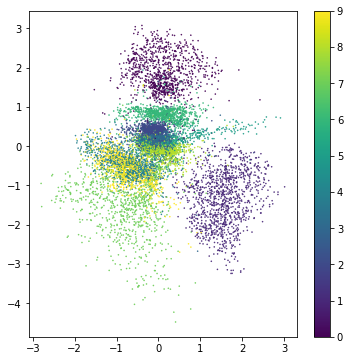

In [ ]:
import matplotlib.pyplot as plt

x_test_encoded = np.array(encoder.predict(x_test, batch_size=16))
# x_test_encoded.shape, y_test.shape
plt.figure(figsize=(6, 6))
x_test_encoded.shape   # 3 * 10000 * 2
x_test_encoded[0,:,1].shape, y_test.shape

plt.scatter(x_test_encoded[2,:,0], x_test_encoded[2,:,1], c=y_test, s=0.3)
plt.colorbar()
plt.show()

- Each of these colored clusters is a type of digit. Close clusters are digits that are structurally similar (i.e. digits that share information in the latent space).

- Because the VAE is a generative model, we can also use it to generate new digits! Here we will scan the latent plane, sampling latent points at regular intervals, and generating the corresponding digit for each of these points. This gives us a visualization of the latent manifold that "generates" the MNIST digits.

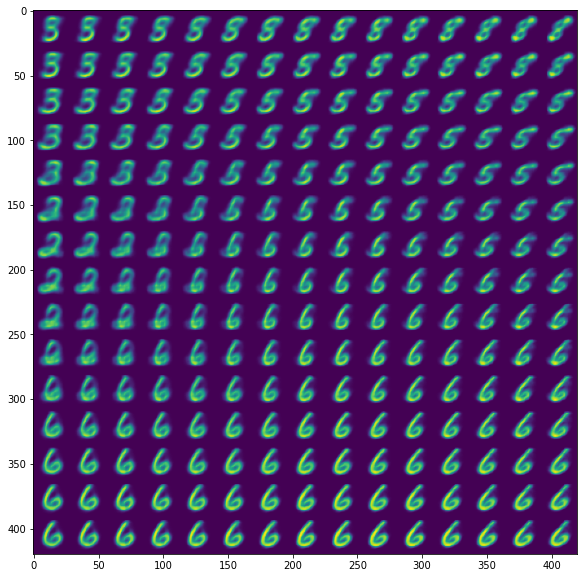

In [ ]:
# Display a 2D manifold of the digits
n = 15  # figure with 15x15 digits

figure = np.zeros((28 * n, 28 * n))
# We will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(0.05, 0.95, n)
grid_y = np.linspace(0.05, 0.95, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(28, 28)
        figure[i * 28: (i + 1) * 28,
               j * 28: (j + 1) * 28] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()

- 